In [1]:
from utils_experiment import (
    load_data,
    filter_data_exp_1,
    AutoGluonProcessor,
    fit_predictors_local,
    fit_predictors_global,
    get_model_list,
    create_output_directories,
    process_and_plot_forecasts,
)

In [2]:
import torch
print("Is cuda available? {}".format(torch.cuda.is_available()))
torch.cuda.get_device_name(torch.cuda.current_device())

torch.__version__

Is cuda available? True


'2.3.1+cu118'

## Experiment 1 Details

Experiment 1 serves as a baseline for comparing the effect of different window lengths for training. The data will be filtered to include only time series that are available in the time period. To investiage the effect of the time series by themselves, the number of covariates is kept constant across all time series and corresponds to the time series fully available from 1986. The specific time periods were chosen with the condition that between each interval, 5 or more new time series were introduced.

| Time Period - 2024     | Maximum number of covariates | Number of covariates used |
|--------------|:-----:| :-----:| 
| 1986 |   94  |   94  |  
| 1997 |   111  |  94  |  
| 2004 |   133  |   94  |  
| 2007 |   146  |  94  |  
| 2010 |   154  |  94  |  
| 2018 |   159  |  94  |  


The cut-off dates are set at 4 yearly intervals between 2020 and 2024. Since the minimum training length for a yearly interval is 2 years, 2020 is the earliest cut-off date we can use.


In [3]:
exp_test_description = "LLMP_comparison"
report_sim_dates = open("experiment_cutoff_dates.txt", 'r').read().split()

target_categories=['Meat', 
                   'Vegetables and vegetable preparations', 
                   'Bakery and cereal products (excluding baby food)'
                  ]
target_categories = [f"food_cpi: {col}" for col in target_categories]

start_year = 1986
random_seed = 42

print("Target Categories:\n" + '\n'.join(target_categories))
print("Report Simulation Dates:\n" + '\n'.join(report_sim_dates))


Target Categories:
food_cpi: Meat
food_cpi: Vegetables and vegetable preparations
food_cpi: Bakery and cereal products (excluding baby food)
Report Simulation Dates:
2017-07-01
2018-07-01
2019-07-01
2020-07-01
2021-07-01
2022-07-01


## Load data

`all_data`: dataframe with all the food cpi variables and all the covariates from 1986 to 2024.\
`foodprice_df`: dataframe with only the food cpi variables from 1986 to 2024.\
`target_categories`: list of the names of the food cpi variables.\
`all_covariates`: dataframe with all the covariates from 1986 to 2024.

In [4]:
file_path = "../data/processed_data/all_data_processed.csv"
all_data, foodprice_df, target_categories, all_covariates = load_data(target_categories, file_path)

In [5]:
foodprice_df

,food_cpi: Meat,food_cpi: Vegetables and vegetable preparations,food_cpi: Bakery and cereal products (excluding baby food)
1986-01-01,65.1,76.0,69.3
1986-02-01,64.2,68.4,70.3
1986-03-01,64.2,66.2,70.6
1986-04-01,63.6,71.1,71.3
1986-05-01,64.0,75.3,71.2
...,...,...,...
2023-09-01,207.5,180.9,196.7
2023-10-01,206.2,176.5,197.6
2023-11-01,207.7,186.7,197.9
2023-12-01,207.4,188.6,197.9


In [6]:
all_data = filter_data_exp_1(all_data, start_year)
processor = AutoGluonProcessor(all_data, target_categories)


# Experiment List

| AutoGluon Model \ Experiment      | local | global | global + covariates |
|--------------|:-----:| :-----: | :-----: |
| NaiveModel |   x  |   |  | 
| SeasonalNaiveModel|   x    |  |  | 
| AutoARIMAModel|   x   |  |  | 
| AutoETSModel|  x  |    |  | 
| DeepARModel|  x   | x |  x | 
| DLinearModel| x   | x |  x| 
| PatchTSTModel|  x   | x | x |   
|SimpleFeedForwardModel|  x   | x | x |   
| TemporalFusionTransformerModel| x  | x | x |   
| DirectTabularModel| x   | x | x | 
|RecursiveTabularModel|  x   | x | x |  
|ChronosModel|  x   | x | x | 

x - model type supported


## Main experiment loop - local models

4 main loops:
- The first loop goes through the list of years at which we want the time window to start, filters out the covariates that are not fully available from 1986.
- The second loop goes though each of the 12 Autogluon models.
- The third loop goes through each of the yearly cut-off dates to trim the training data.
- The fourth loop goes through each of the 9 food categories, gets the training data in the AutoGluon format for local models and plot each prediction period againt the actual values.

In [7]:
# EXP_BASE = "ag_local"
# EXP_MODEL_LIST = get_model_list(EXP_BASE)

# for model_type in EXP_MODEL_LIST:
#     EXPERIMENT_NAME = f"{EXP_BASE}_{model_type}"

#     for cutoff_date in report_sim_dates:
#         forecast_output_dir, plot_output_dir, training_output_dir, model_dir = (
#             create_output_directories(
#                 exp_test_description,
#                 start_year,
#                 EXPERIMENT_NAME,
#                 cutoff_date,
#                 random_seed
#             )
#         )

#         for category in target_categories:
#             train_data = processor.get_autogluon_local_df(category, cutoff_date)
#             predictor = fit_predictors_local(model_type, model_dir, train_data, category, random_seed)
#             process_and_plot_forecasts(
#                 predictor,
#                 train_data,
#                 category,
#                 training_output_dir,
#                 forecast_output_dir,
#                 plot_output_dir,
#                 foodprice_df,
#                 cutoff_date
#             )

# Main experiment loop - global models

5 main loops:
- The first loop goes through the list of years at which we want the time window to start, filters out the covariates that are not fully available from 1986.
- The second loop goes though the two experiment base (global and global+covariates)
- The third loop goes though 8 Autogluon models, excluding all statistical models (Naive, SeasonalNaive, AutoArima, AutoETS).
- The fourth loop goes through each of the yearly cut-off dates to trim the training data.
- The fifth loop goes through each of the 9 food categories, gets the training data in the AutoGluon format depending on the experiment base and plot each prediction period againt the actual values.

['TemporalFusionTransformerModel']
TemporalFusionTransformerModel


Beginning AutoGluon training... Time limit = 1800s
AutoGluon will save models to './output/LLMP_comparison/ag_global_cpi_with_covariates_TemporalFusionTransformerModel/random_seed_42/2017-07-01/model_files/'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.8.20
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #147~18.04.1-Ubuntu SMP Sat Oct 15 13:10:18 UTC 2022
CPU Count:          40
GPU Count:          1
Memory Avail:       136.38 GB / 188.59 GB (72.3%)
Disk Space Avail:   17480.55 GB / 249006.62 GB (7.0%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAPE,
 'excluded_model_types': ['DirectTabular'],
 'hyperparameters': {'TemporalFusionTransformerModel': {}},
 'known_covariates_names': [],
 'num_val_windows': 3,
 'prediction_length': 18,
 'quantile_levels': [0.01, 0.05, 0.1, 0.25, 0.75, 0.9, 0.95, 0.99],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_sel

TemporalFusionTransformerModel



AutoGluon will gauge predictive performance using evaluation metric: 'MAPE'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2024-10-16 16:11:22
Excluded model types: ['DirectTabular']
Models that will be trained: ['TemporalFusionTransformer']
Training timeseries model TemporalFusionTransformer. Training for up to 1799.9s of the 1799.9s of remaining time.
	-0.0305       = Validation score (-MAPE)
	173.97  s     = Training runtime
	0.09    s     = Validation (prediction) runtime
Not fitting ensemble as only 1 model was trained.
Training complete. Models trained: ['TemporalFusionTransformer']
Total runtime: 174.12 s
Best model: TemporalFusionTransformer
Best model score: -0.0305
Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer


****************** Summary of fit() ******************
Estimated performance of each model:
                       model  score_val  pred_time_val  fit_time_marginal  \
0  TemporalFusionTransformer  -0.030517       0.086678         173.971954   

   fit_order  
0          1  
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer


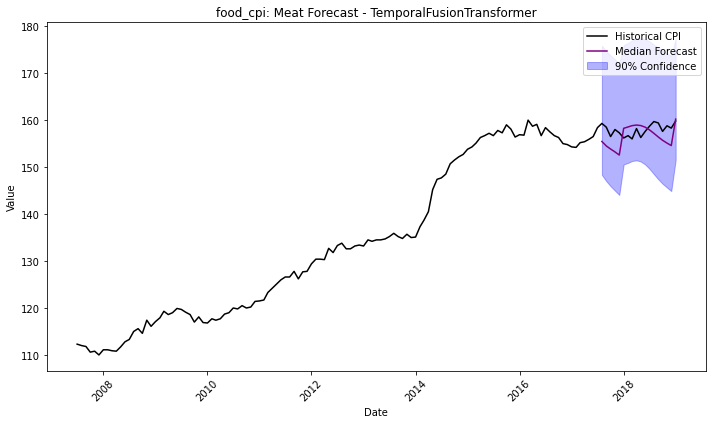

Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer
Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer


****************** Summary of fit() ******************
Estimated performance of each model:
                       model  score_val  pred_time_val  fit_time_marginal  \
0  TemporalFusionTransformer  -0.030517       0.086678         173.971954   

   fit_order  
0          1  
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


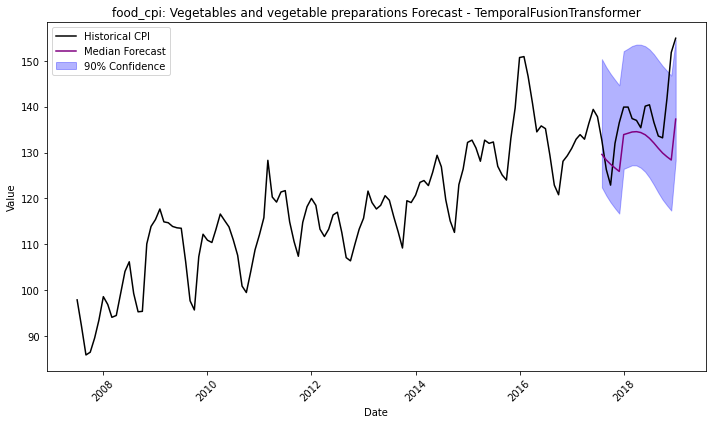

Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer
Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer


****************** Summary of fit() ******************
Estimated performance of each model:
                       model  score_val  pred_time_val  fit_time_marginal  \
0  TemporalFusionTransformer  -0.030517       0.086678         173.971954   

   fit_order  
0          1  
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


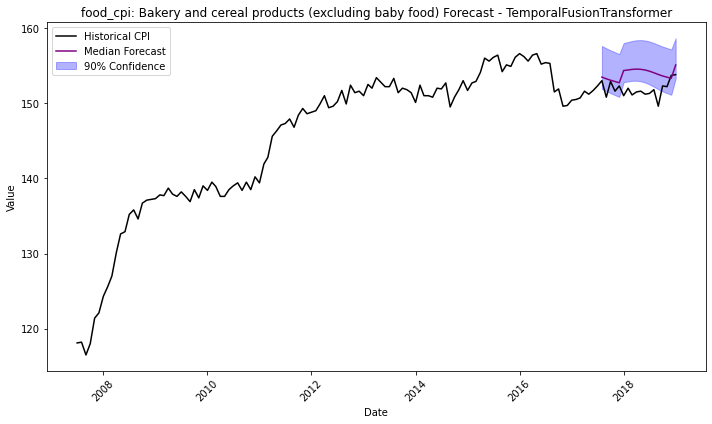

Beginning AutoGluon training... Time limit = 1800s
AutoGluon will save models to './output/LLMP_comparison/ag_global_cpi_with_covariates_TemporalFusionTransformerModel/random_seed_42/2018-07-01/model_files/'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.8.20
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #147~18.04.1-Ubuntu SMP Sat Oct 15 13:10:18 UTC 2022
CPU Count:          40
GPU Count:          1
Memory Avail:       136.24 GB / 188.59 GB (72.2%)
Disk Space Avail:   17479.04 GB / 249006.62 GB (7.0%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAPE,
 'excluded_model_types': ['DirectTabular'],
 'hyperparameters': {'TemporalFusionTransformerModel': {}},
 'known_covariates_names': [],
 'num_val_windows': 3,
 'prediction_length': 18,
 'quantile_levels': [0.01, 0.05, 0.1, 0.25, 0.75, 0.9, 0.95, 0.99],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_sel

TemporalFusionTransformerModel



AutoGluon will gauge predictive performance using evaluation metric: 'MAPE'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2024-10-16 16:14:18
Excluded model types: ['DirectTabular']
Models that will be trained: ['TemporalFusionTransformer']
Training timeseries model TemporalFusionTransformer. Training for up to 1799.9s of the 1799.9s of remaining time.
	-0.0374       = Validation score (-MAPE)
	160.60  s     = Training runtime
	0.08    s     = Validation (prediction) runtime
Not fitting ensemble as only 1 model was trained.
Training complete. Models trained: ['TemporalFusionTransformer']
Total runtime: 160.74 s
Best model: TemporalFusionTransformer
Best model score: -0.0374
Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer


****************** Summary of fit() ******************
Estimated performance of each model:
                       model  score_val  pred_time_val  fit_time_marginal  \
0  TemporalFusionTransformer  -0.037358       0.079705         160.599427   

   fit_order  
0          1  
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer


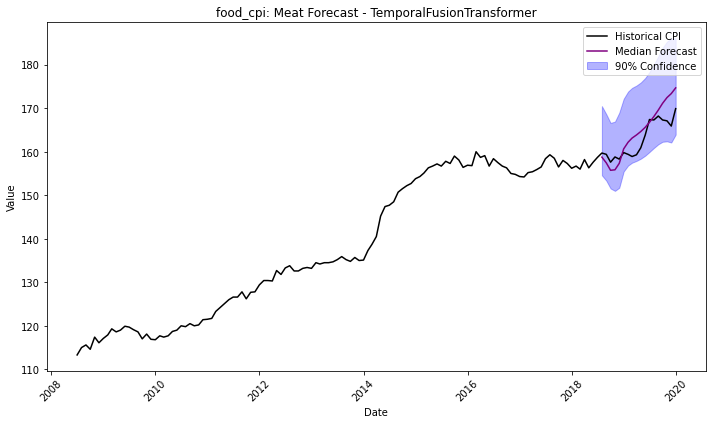

Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer
Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer


****************** Summary of fit() ******************
Estimated performance of each model:
                       model  score_val  pred_time_val  fit_time_marginal  \
0  TemporalFusionTransformer  -0.037358       0.079705         160.599427   

   fit_order  
0          1  
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


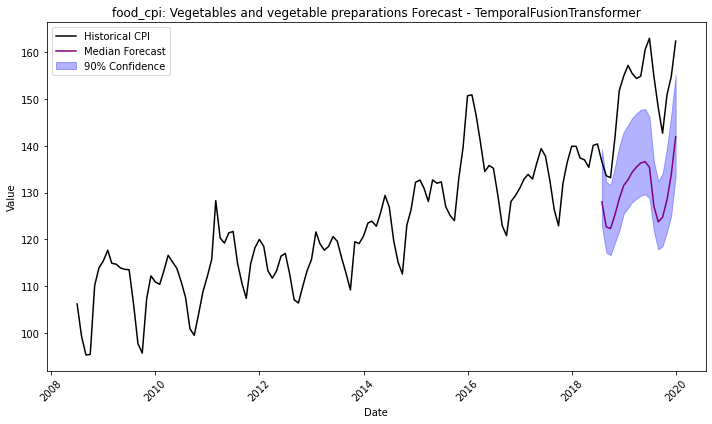

Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer
Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer


****************** Summary of fit() ******************
Estimated performance of each model:
                       model  score_val  pred_time_val  fit_time_marginal  \
0  TemporalFusionTransformer  -0.037358       0.079705         160.599427   

   fit_order  
0          1  
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


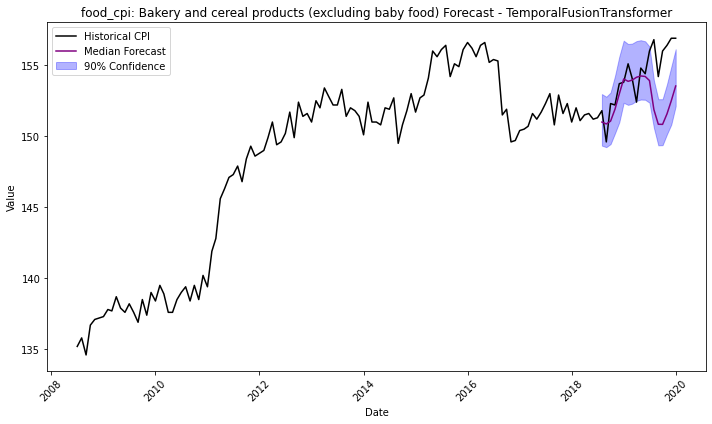

Beginning AutoGluon training... Time limit = 1800s
AutoGluon will save models to './output/LLMP_comparison/ag_global_cpi_with_covariates_TemporalFusionTransformerModel/random_seed_42/2019-07-01/model_files/'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.8.20
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #147~18.04.1-Ubuntu SMP Sat Oct 15 13:10:18 UTC 2022
CPU Count:          40
GPU Count:          1
Memory Avail:       137.30 GB / 188.59 GB (72.8%)
Disk Space Avail:   17474.14 GB / 249006.62 GB (7.0%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAPE,
 'excluded_model_types': ['DirectTabular'],
 'hyperparameters': {'TemporalFusionTransformerModel': {}},
 'known_covariates_names': [],
 'num_val_windows': 3,
 'prediction_length': 18,
 'quantile_levels': [0.01, 0.05, 0.1, 0.25, 0.75, 0.9, 0.95, 0.99],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_sel

TemporalFusionTransformerModel


	past_covariates:
		categorical:        []
		continuous (float): ['exogenous_swe_sr: SWE', 'exogenous_po...rtainty Index', 'exogenous_ap... APU000072610', 'exogenous_cw...: CWUR0000SA0', 'exogenous_excaus: EXCAUS', 'exogenous_fmpi: PCU311311', ...]

To learn how to fix incorrectly inferred types, please see documentation for TimeSeriesPredictor.fit

AutoGluon will gauge predictive performance using evaluation metric: 'MAPE'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2024-10-16 16:17:01
Excluded model types: ['DirectTabular']
Models that will be trained: ['TemporalFusionTransformer']
Training timeseries model TemporalFusionTransformer. Training for up to 1799.9s of the 1799.9s of remaining time.
	-0.0317       = Validation score (-MAPE)
	158.12  s     = Training runtime
	0.07    s     = Validation (prediction) runtime
Not fitting ensemble as only 1 model was

****************** Summary of fit() ******************
Estimated performance of each model:
                       model  score_val  pred_time_val  fit_time_marginal  \
0  TemporalFusionTransformer  -0.031699       0.073858         158.124559   

   fit_order  
0          1  
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer


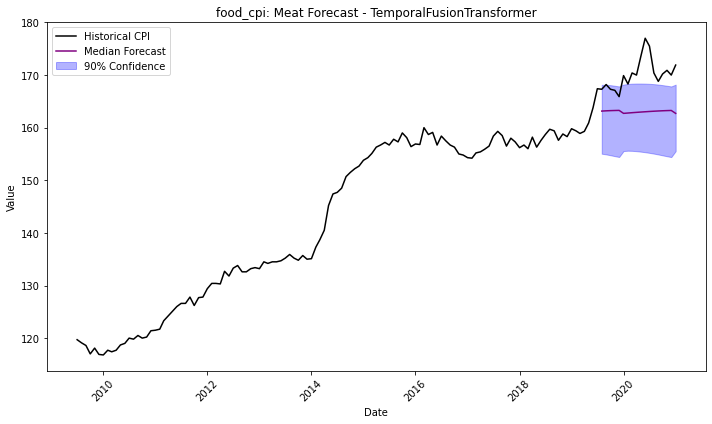

Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer
Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer


****************** Summary of fit() ******************
Estimated performance of each model:
                       model  score_val  pred_time_val  fit_time_marginal  \
0  TemporalFusionTransformer  -0.031699       0.073858         158.124559   

   fit_order  
0          1  
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


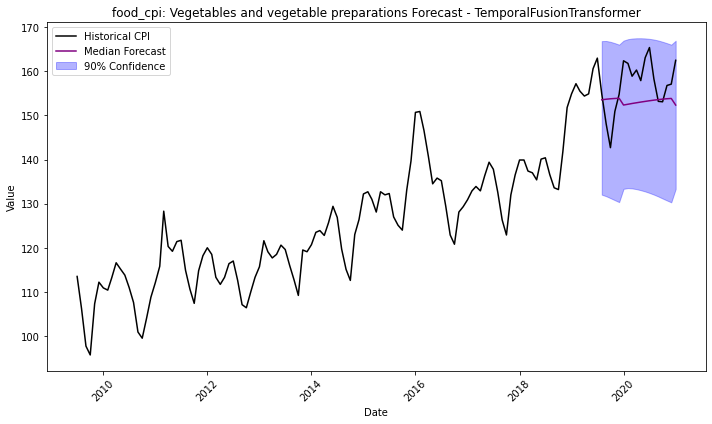

Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer
Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer


****************** Summary of fit() ******************
Estimated performance of each model:
                       model  score_val  pred_time_val  fit_time_marginal  \
0  TemporalFusionTransformer  -0.031699       0.073858         158.124559   

   fit_order  
0          1  
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


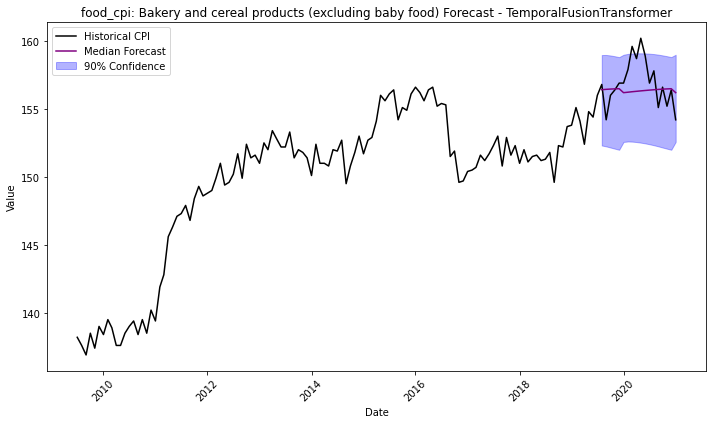

Beginning AutoGluon training... Time limit = 1800s
AutoGluon will save models to './output/LLMP_comparison/ag_global_cpi_with_covariates_TemporalFusionTransformerModel/random_seed_42/2020-07-01/model_files/'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.8.20
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #147~18.04.1-Ubuntu SMP Sat Oct 15 13:10:18 UTC 2022
CPU Count:          40
GPU Count:          1
Memory Avail:       147.50 GB / 188.59 GB (78.2%)
Disk Space Avail:   17470.82 GB / 249006.62 GB (7.0%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAPE,
 'excluded_model_types': ['DirectTabular'],
 'hyperparameters': {'TemporalFusionTransformerModel': {}},
 'known_covariates_names': [],
 'num_val_windows': 3,
 'prediction_length': 18,
 'quantile_levels': [0.01, 0.05, 0.1, 0.25, 0.75, 0.9, 0.95, 0.99],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_sel

TemporalFusionTransformerModel


	past_covariates:
		categorical:        []
		continuous (float): ['exogenous_swe_sr: SWE', 'exogenous_po...rtainty Index', 'exogenous_ap... APU000072610', 'exogenous_cw...: CWUR0000SA0', 'exogenous_excaus: EXCAUS', 'exogenous_fmpi: PCU311311', ...]

To learn how to fix incorrectly inferred types, please see documentation for TimeSeriesPredictor.fit

AutoGluon will gauge predictive performance using evaluation metric: 'MAPE'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2024-10-16 16:19:41
Excluded model types: ['DirectTabular']
Models that will be trained: ['TemporalFusionTransformer']
Training timeseries model TemporalFusionTransformer. Training for up to 1799.9s of the 1799.9s of remaining time.
	-0.0286       = Validation score (-MAPE)
	164.83  s     = Training runtime
	0.08    s     = Validation (prediction) runtime
Not fitting ensemble as only 1 model was

****************** Summary of fit() ******************
Estimated performance of each model:
                       model  score_val  pred_time_val  fit_time_marginal  \
0  TemporalFusionTransformer  -0.028591       0.076716          164.83453   

   fit_order  
0          1  
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer


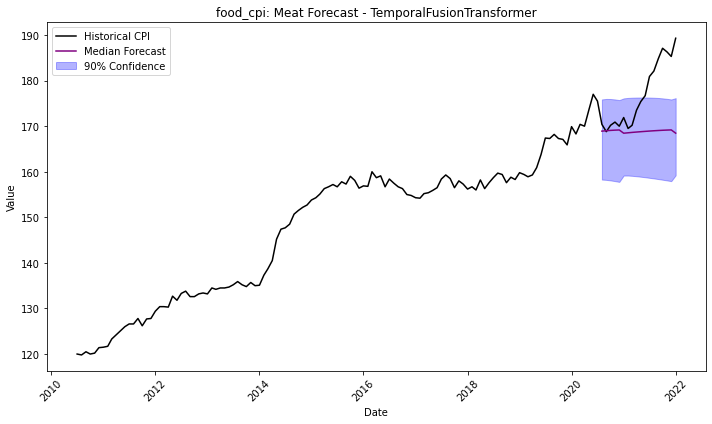

Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer
Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer


****************** Summary of fit() ******************
Estimated performance of each model:
                       model  score_val  pred_time_val  fit_time_marginal  \
0  TemporalFusionTransformer  -0.028591       0.076716          164.83453   

   fit_order  
0          1  
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


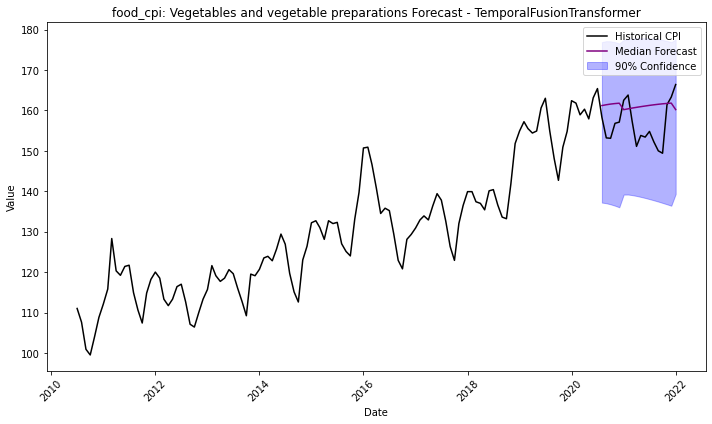

Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer
Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer


****************** Summary of fit() ******************
Estimated performance of each model:
                       model  score_val  pred_time_val  fit_time_marginal  \
0  TemporalFusionTransformer  -0.028591       0.076716          164.83453   

   fit_order  
0          1  
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


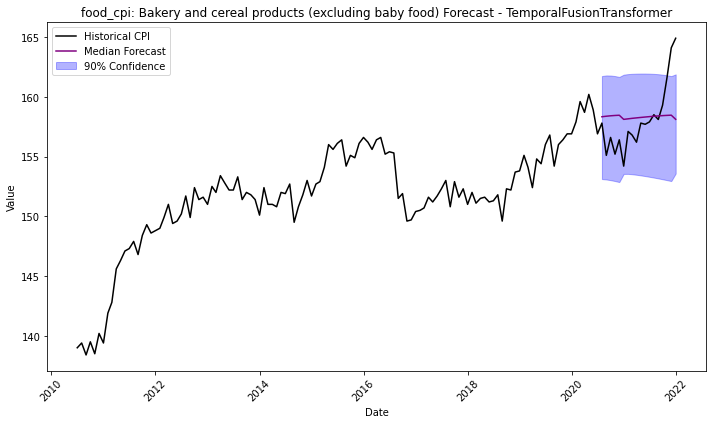

Beginning AutoGluon training... Time limit = 1800s
AutoGluon will save models to './output/LLMP_comparison/ag_global_cpi_with_covariates_TemporalFusionTransformerModel/random_seed_42/2021-07-01/model_files/'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.8.20
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #147~18.04.1-Ubuntu SMP Sat Oct 15 13:10:18 UTC 2022
CPU Count:          40
GPU Count:          1
Memory Avail:       139.27 GB / 188.59 GB (73.8%)
Disk Space Avail:   17463.95 GB / 249006.62 GB (7.0%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAPE,
 'excluded_model_types': ['DirectTabular'],
 'hyperparameters': {'TemporalFusionTransformerModel': {}},
 'known_covariates_names': [],
 'num_val_windows': 3,
 'prediction_length': 18,
 'quantile_levels': [0.01, 0.05, 0.1, 0.25, 0.75, 0.9, 0.95, 0.99],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_sel

TemporalFusionTransformerModel


	-0.0284       = Validation score (-MAPE)
	167.24  s     = Training runtime
	0.07    s     = Validation (prediction) runtime
Not fitting ensemble as only 1 model was trained.
Training complete. Models trained: ['TemporalFusionTransformer']
Total runtime: 167.35 s
Best model: TemporalFusionTransformer
Best model score: -0.0284
Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer


****************** Summary of fit() ******************
Estimated performance of each model:
                       model  score_val  pred_time_val  fit_time_marginal  \
0  TemporalFusionTransformer  -0.028415       0.073799         167.241178   

   fit_order  
0          1  
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer


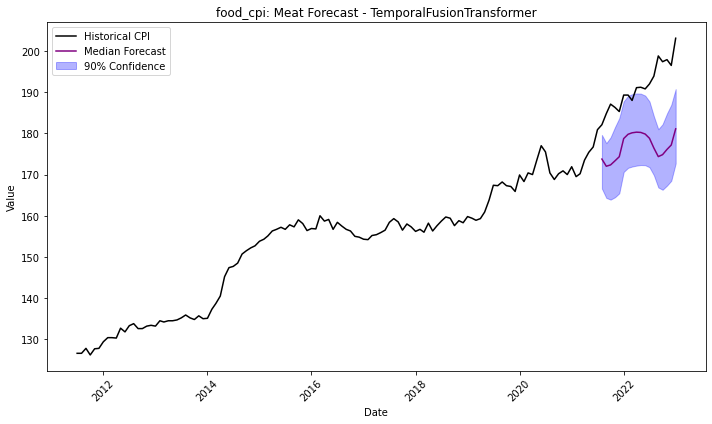

Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer
Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer


****************** Summary of fit() ******************
Estimated performance of each model:
                       model  score_val  pred_time_val  fit_time_marginal  \
0  TemporalFusionTransformer  -0.028415       0.073799         167.241178   

   fit_order  
0          1  
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


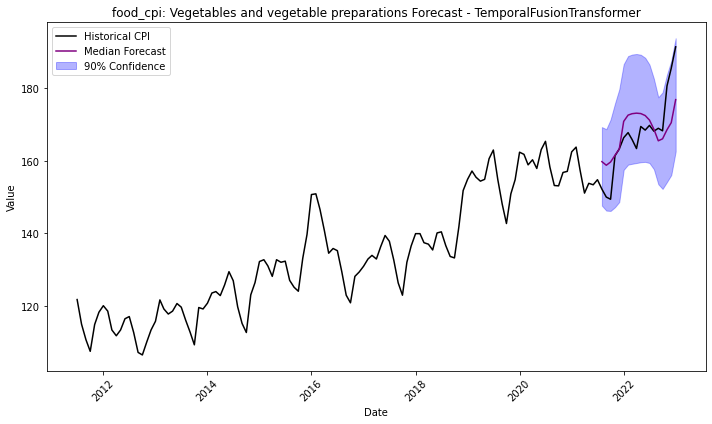

Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer


****************** Summary of fit() ******************
Estimated performance of each model:
                       model  score_val  pred_time_val  fit_time_marginal  \
0  TemporalFusionTransformer  -0.028415       0.073799         167.241178   

   fit_order  
0          1  
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer


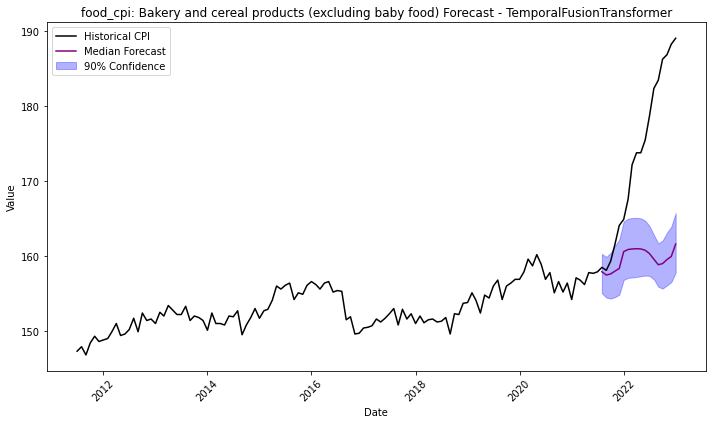

Beginning AutoGluon training... Time limit = 1800s
AutoGluon will save models to './output/LLMP_comparison/ag_global_cpi_with_covariates_TemporalFusionTransformerModel/random_seed_42/2022-07-01/model_files/'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.8.20
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #147~18.04.1-Ubuntu SMP Sat Oct 15 13:10:18 UTC 2022
CPU Count:          40
GPU Count:          1
Memory Avail:       141.74 GB / 188.59 GB (75.2%)
Disk Space Avail:   17456.61 GB / 249006.62 GB (7.0%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAPE,
 'excluded_model_types': ['DirectTabular'],
 'hyperparameters': {'TemporalFusionTransformerModel': {}},
 'known_covariates_names': [],
 'num_val_windows': 3,
 'prediction_length': 18,
 'quantile_levels': [0.01, 0.05, 0.1, 0.25, 0.75, 0.9, 0.95, 0.99],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_sel

TemporalFusionTransformerModel


	past_covariates:
		categorical:        []
		continuous (float): ['exogenous_swe_sr: SWE', 'exogenous_po...rtainty Index', 'exogenous_ap... APU000072610', 'exogenous_cw...: CWUR0000SA0', 'exogenous_excaus: EXCAUS', 'exogenous_fmpi: PCU311311', ...]

To learn how to fix incorrectly inferred types, please see documentation for TimeSeriesPredictor.fit

AutoGluon will gauge predictive performance using evaluation metric: 'MAPE'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2024-10-16 16:25:17
Excluded model types: ['DirectTabular']
Models that will be trained: ['TemporalFusionTransformer']
Training timeseries model TemporalFusionTransformer. Training for up to 1800.0s of the 1800.0s of remaining time.
	-0.0350       = Validation score (-MAPE)
	152.13  s     = Training runtime
	0.08    s     = Validation (prediction) runtime
Not fitting ensemble as only 1 model was

****************** Summary of fit() ******************
Estimated performance of each model:
                       model  score_val  pred_time_val  fit_time_marginal  \
0  TemporalFusionTransformer  -0.035032       0.076106         152.127467   

   fit_order  
0          1  
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer


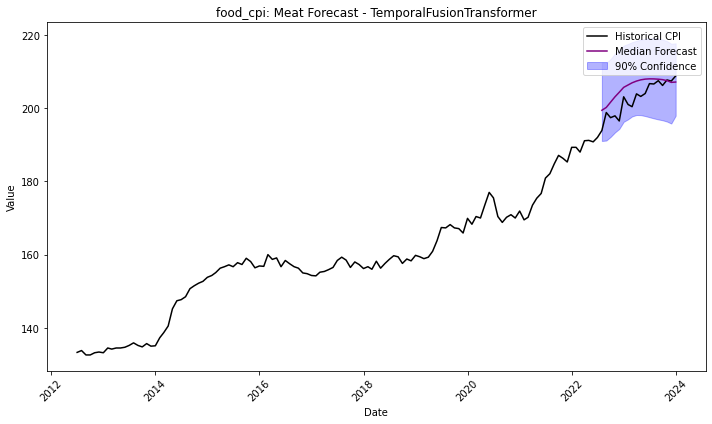

Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer
Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer


****************** Summary of fit() ******************
Estimated performance of each model:
                       model  score_val  pred_time_val  fit_time_marginal  \
0  TemporalFusionTransformer  -0.035032       0.076106         152.127467   

   fit_order  
0          1  
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


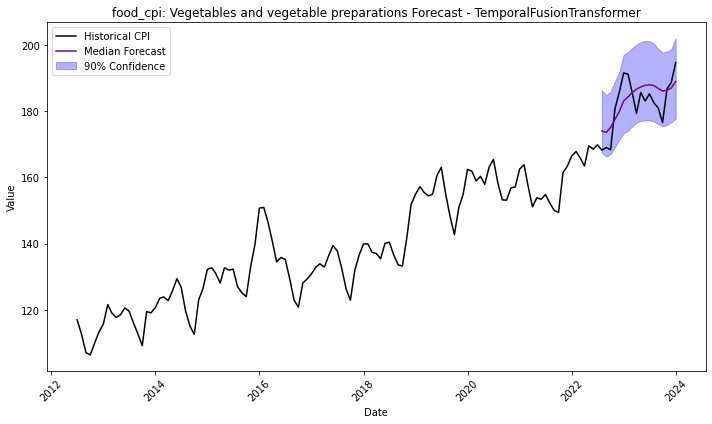

Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer
Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer


****************** Summary of fit() ******************
Estimated performance of each model:
                       model  score_val  pred_time_val  fit_time_marginal  \
0  TemporalFusionTransformer  -0.035032       0.076106         152.127467   

   fit_order  
0          1  
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


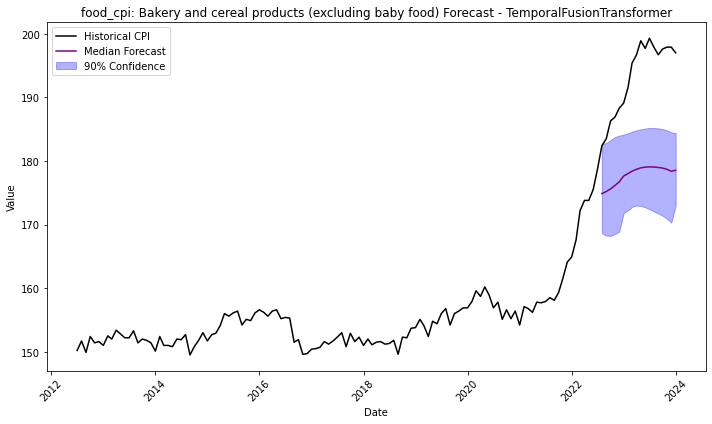

In [10]:
EXP_BASE_LIST_GLOBAL = ["ag_global_all", "ag_global_cpi_with_covariates"]


for EXP_BASE in EXP_BASE_LIST_GLOBAL:

    EXP_MODEL_LIST = get_model_list(EXP_BASE)
    
    print(EXP_MODEL_LIST)

    for model_type in EXP_MODEL_LIST:
        print(model_type)
        
        
        EXPERIMENT_NAME = f"{EXP_BASE}_{model_type}"

        for cutoff_date in report_sim_dates:
            forecast_output_dir, plot_output_dir, training_output_dir, model_dir = (
                create_output_directories(
                    exp_test_description,
                    start_year,
                    EXPERIMENT_NAME,
                    cutoff_date,
                    random_seed
                )
            )

            if "_covariates" in EXP_BASE:
                train_data = processor.get_autogluon_global_with_covariates_df(
                    cutoff_date
                )
            else:
                train_data = processor.get_autogluon_global_df(cutoff_date)

            predictor = fit_predictors_global(model_type, model_dir, train_data, random_seed)

            for category in target_categories:
                process_and_plot_forecasts(
                    predictor,
                    train_data,
                    category,
                    training_output_dir,
                    forecast_output_dir,
                    plot_output_dir,
                    foodprice_df,
                    cutoff_date
                )

In [ ]:
train_data